In [1]:

####################################################################################################
####################################################################################################

import sys
import os

import datetime
import matplotlib.pyplot as plt
import numpy as np
import numba
import pandas as pd
import pprint

from IPython.display import clear_output
from IPython.display import display

sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath("../pax"))

from pax_utils import event_utils
from pax_utils import file_utils
from pax_utils import interaction_utils
from pax_utils import s1s2_utils
from pax_utils import waveform_utils
from pax_utils import waveform_raw_utils
from pax_utils import waveform_pe_utils

from pax.configuration import load_configuration

pp = pprint.PrettyPrinter(depth=2)



In [2]:

####################################################################################################
####################################################################################################

f = plt.figure(figsize=(30, 15))

def processPklEvents(zipfilename):

    ################################################################################################
    ################################################################################################
    
    lst_pkl_files  = file_utils.getListOfPklFilesFromZipFile(zipfilename, nEventsPerFile)

    
    ################################################################################################
    ################################################################################################
    
    intr0  = None
    sum_wf = None
    event  = None

    df_zip_merged = pd.DataFrame()
    
        
    ################################################################################################
    ################################################################################################
    
    for iPklFile in range(0, len(lst_pkl_files)):
    
        ############################################################################################
        ############################################################################################

        print("File: '" + str(zipfilename) + "'")
        print("   event_number: " + str(iPklFile))
        #clear_output(wait=True)
        
        
        ############################################################################################
        ############################################################################################

        jsonfilename = os.path.dirname(zipfilename) + '/pax_info.json'
        print("   CFG: '" + str(jsonfilename) + "'")
        
        cfg = event_utils.getConfig(jsonfilename)
        
        
        ############################################################################################
        ############################################################################################
        
        pklfilename  = lst_pkl_files[iPklFile]
        event        = file_utils.getPaxEventFromPklFileInZipArchive(zipfilename, pklfilename)

        
        ############################################################################################
        ############################################################################################
        
        interactions  = event.interactions
        nInteractions = len(interactions)
        
        if (nInteractions != 1): continue
        
        
        ############################################################################################
        ############################################################################################

        intr0 = None
        
        if (len(interactions) > 0):
            
            intr0 = interactions[0]
            
            
        ############################################################################################
        ############################################################################################
        
        df_pkl_event  = event_utils.getEventDataFrameFromEvent(event)
        df_pkl_intr   = interaction_utils.getInteractionDataFrameFromEvent(event)
        df_pkl_s2s    = s1s2_utils.getS2integralsDataFrame(event, 127)
        df_pkl_merged = df_pkl_event.merge(df_pkl_intr).merge(df_pkl_s2s)
        df_zip_merged = df_zip_merged.append(df_pkl_merged)
        
              
        ############################################################################################
        # S2 Window from Event
        ############################################################################################
        
        left  = event.main_s2.left
        right = event.main_s2.right
        
    
        ############################################################################################
        # Raw Waveforms
        ############################################################################################
    
        arr_summed_waveform_raw_evt = waveform_utils.getSummedWaveformFromEvent(event, 'tpc_raw')[left:right]
        df_channels_waveforms_raw   = waveform_raw_utils.getChannelWaveformsDataFrameRaw(event, cfg)
        arr_summed_waveform_raw_df  = waveform_utils.getSummedWaveformFromDataFrame(df_channels_waveforms_raw, event)
        arr_summed_waveform_raw_df  = arr_summed_waveform_raw_df[left:right]
        
        f = plt.figure(figsize=(10, 5))
        plt.plot(arr_summed_waveform_raw_evt, color='b', label='Raw Summed Waveform from Event') 
        plt.plot(arr_summed_waveform_raw_df , color='r', label='Raw Summed Waveform by Hand DF') 
        plt.legend(fontsize=18)
        
        eq_raw = waveform_utils.compareWaveforms(arr_summed_waveform_raw_evt, arr_summed_waveform_raw_df)
                                                                                      
        if (not eq_raw):
            
            raise Exception("Error! RAW Waveforms summed over channels by hand differ from event (DF).")
            
            return
    
        
        
        ############################################################################################
        # TPC Summed Waveform
        ############################################################################################
        
        arr_summed_waveform_tpc_evt = waveform_utils.getSummedWaveformFromEvent(event, 'tpc')[left:right]
        #arr_summed_waveform_tpc_tst = waveform_pe_utils.getSummedWaveform(event, cfg)[left:right]
        df_channels_waveforms_tpc   = waveform_pe_utils.getChannelWaveformsDataFrameTpc(event, cfg)
        arr_summed_waveform_tpc_df  = waveform_utils.getSummedWaveformFromDataFrame(df_channels_waveforms_tpc, event)
        arr_summed_waveform_tpc_df  = arr_summed_waveform_tpc_df[left:right]
        
        f = plt.figure(figsize=(10, 5))
        plt.plot(arr_summed_waveform_tpc_evt, color='b', label='TPC Summed Waveform from Event') 
        #plt.plot(arr_summed_waveform_tpc_tst, color='g', label='TPC Summed Waveform from Test') 
        plt.plot(arr_summed_waveform_tpc_df , color='r', label='TPC Summed Waveform by Hand DF') 
        plt.legend(fontsize=18)
        
        #eq_tpc0 = waveform_utils.compareWaveforms(arr_summed_waveform_tpc_evt, arr_summed_waveform_tpc_tst)
        eq_tpc1 = waveform_utils.compareWaveforms(arr_summed_waveform_tpc_evt, arr_summed_waveform_tpc_df)
                                                                                      
       
      
        #
        continue
        
    
               
                
        #############################################################################################
        ## Sanity
        #############################################################################################
#
        #event_sum_wf  = np.sum(evt_summed_waveform_top)
        #event_sum_s2s = np.sum(df_pkl_s2s.drop(columns=['event_number']).as_matrix(), axis=1) 
        #
        #print()
        #print("Event Sum Waveform: " + str(event_sum_wf))
        #print("Event Sum S2's:     " + str(event_sum_s2s))

       
    
        #############################################################################################
        #############################################################################################

        assert(18 == len(event.get_sum_waveform_names()))
        
        #for name in event.get_sum_waveform_names(): print(name)

            
        ############################################################################################
        ############################################################################################
    
        continue
            
    
    ################################################################################################
    ################################################################################################
    
    #plt.legend()
    
    df_zip_merged.reset_index(inplace=True, drop=True)
       
    return df_zip_merged, event, intr0, sum_wf

    

File: '../pax_run/pax_output/Mar25/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
   event_number: 0
   CFG: '../pax_run/pax_output/Mar25/instructions_000000/pax_info.json'
File: '../pax_run/pax_output/Mar25/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
   event_number: 1
   CFG: '../pax_run/pax_output/Mar25/instructions_000000/pax_info.json'
Arrays are equal within 1e-05
top channels: 248
Arrays are equal within 1e-05


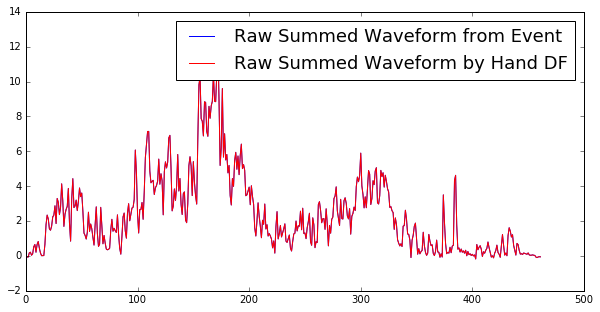

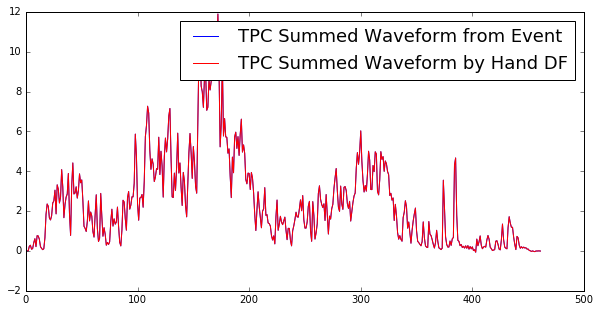

In [3]:

####################################################################################################
####################################################################################################

zipfilename    = '../pax_run/pax_output/Mar25/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
nEventsPerFile = 2


df_zip_merged, event, intr, wf_sum = processPklEvents(zipfilename)


    